## PDC ROP model

In [1]:
import numpy as np
import pandas as pd
import math
import matplotlib.pylab as plt
from scipy.optimize import curve_fit
import seaborn as sns
import itertools
from math import pi
from matplotlib.legend_handler import HandlerPatch
from scipy.optimize import curve_fit
from SALib.sample import saltelli
from SALib.analyze import sobol


### Model

In [2]:
def Akhtarmanesh_etal_ROP(WOB,RPM,RS,NOC,BR,SR,Dc,NOB,Db):
    


    try:
        
        #Saman model phase I and II
        WOCt = 270*((RPM/80)**0.1)*(11/NOC)*((math.tan(math.radians(BR))/math.tan(math.radians(25)))**0.2)*(Dc/0.51)*(RS/28000)
        # print('WOCt = ', WOCt)                                               
        DOCt = 0.018*((80/RPM)**0.3)*(11/NOC)*(Dc/0.51)
        # print('DOCt = ', DOCt) 
        WOBt = WOCt*NOC
        # print('WOBt = ', WOBt) 
        ROPt = DOCt*RPM*5
        # print('ROPt = ', ROPt) 
        ARS = RS*(1+0.3*(RPM/100))
        # print('ARS = ', ARS) 

        G = 880*((NOB**0.3)/(NOC**1.05))*(Dc*math.cos(math.radians(SR)))/(Db**2)*(math.tan(math.radians(BR))**0.2)
        # print('G = ', G) 
        
        if WOB < WOBt:


            # phase I
            ROP = 0.000002*G*((RPM**0.7)*(WOB**2.6))/ARS
        else:
            # phase II
            ROP = G*(RPM*(WOB-WOBt))/ARS + ROPt
            
    except ZeroDivisionError:
        
        ROP = 999999
        
    return ROP

### Data

### Bits 


PDC bits manufactured by National Oil Varco - NOV (left) and Ulterra (right) are seen at the following image.
<p align="left">
  <img  width="450" src="NOV_bits.PNG" >
  <img  width="450" src="Ulterra_bits.PNG" >
</p>

### Data
The four-row of data used in this study are seen in the following table.

###### Table
```
|   year | name       |     WOB |   ROP data |   Db |   RPM |   UCS |   NOC |   BR |   SR |   Dc |   NOB |
|--------|------------|---------|------------|------|-------|-------|-------|------|------|------|-------|
|   2019 | SWG        | 2543.8  |    6.2     | 3.75 |    80 | 28000 |    11 |   25 |    1 | 0.51 |     4 |
|   2019 | SWG        | 3048.9  |   11.9     | 3.75 |    80 | 28000 |    11 |   25 |    1 | 0.51 |     4 |
|   2019 | SWG        | 3538.7  |   19.5     | 3.75 |    80 | 28000 |    11 |   25 |    1 | 0.51 |     4 |
|   2019 | SWG        | 4066.2  |   28.6     | 3.75 |    80 | 28000 |    11 |   25 |    1 | 0.51 |     4 |
```
###### Data Dimensions

```
WOB is in lbf
ROP data is in ft/hr
Db is in inch
RPM is in rpm
UCS is in psi
NOC is dimensionless
BR is dimensionless
Dc is in inch
NOB is dimensionless
```

### Read data

In [3]:
data = pd.read_csv("ROP data.csv")
data.head()

,year,name,WOB,ROP data,Db,RPM,UCS,NOC,BR,SR,Dc,NOB
0,2015,SWG_4B_100,2300,9.9,3.75,100,28000,8,15,1,0.43,4
1,2015,SWG_4B_100,2420,11.0,3.75,100,28000,8,15,1,0.43,4
2,2015,SWG_4B_100,2660,14.7,3.75,100,28000,8,15,1,0.43,4
3,2015,SWG_4B_100,2910,18.1,3.75,100,28000,8,15,1,0.43,4
4,2015,SWG_4B_100,3180,22.6,3.75,100,28000,8,15,1,0.43,4


In [4]:
data.tail()

,year,name,WOB,ROP data,Db,RPM,UCS,NOC,BR,SR,Dc,NOB
78,2020,SWG,3019,9.2,3.75,160,28000,13,25,1,0.51,5
79,2020,SWG,3520,13.6,3.75,160,28000,13,25,1,0.51,5
80,2020,SWG,4017,20.1,3.75,160,28000,13,25,1,0.51,5
81,2020,SWG,4520,27.7,3.75,160,28000,13,25,1,0.51,5
82,2021,SWG,5016,37.3,3.75,160,28000,13,25,1,0.51,5


In [5]:
WOB_list = list(data['WOB'])
RPM_list = list(data['RPM'])
Db_list = list(data['Db'])
RS_list = list(data['UCS'])
NOC_list = list(data['NOC'])
NOB_list = list(data['NOB'])
BR_list = list(data['BR'])
SR_list = list(data['SR'])
Dc_list = list(data['Dc'])

ROP_data_list = list(data['ROP data'])

### Comparison between model and data

In [6]:
model_rop = [Akhtarmanesh_etal_ROP(WOB,RPM,RS,NOC,BR,SR,Dc,NOB,Db) \
             for (WOB,RPM,RS,NOC,BR,SR,Dc,NOB,Db) in \
             zip(WOB_list, RPM_list, RS_list,NOC_list, 
                 BR_list, SR_list,Dc_list, NOB_list,Db_list)]

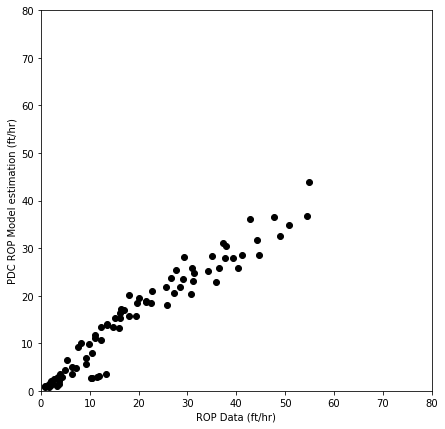

In [7]:
plt.figure(figsize=(7,7))
plt.scatter(ROP_data_list, model_rop, c='k')
plt.xlim(0,80)
plt.xlabel("ROP Data (ft/hr)")
plt.ylim(0,80)
plt.ylabel("PDC ROP Model estimation (ft/hr)")
plt.show()

### Parameters Interaction Visualization 

In [8]:
problem = {
    'num_vars': 9,
    'names': ['WOB','RPM','RS','NOC','BR','SR','Dc','NOB','Db'],
    'bounds': [[1000,10_000],
              [30,350],
              [10_000,35_000],
              [4,15],
              [5,25],
              [1,3],
              [0.4,0.75],
              [4,15],
              [3,12.25]]}

In [9]:
def evaluate_model(row):
    WOB,RPM,RS,NOC,BR,SR,Dc,NOB,Db = row
    ROP = Akhtarmanesh_etal_ROP(WOB,RPM,RS,NOC,BR,SR,Dc,NOB,Db)
    return ROP

In [10]:
param_values = saltelli.sample(problem, 1024)

Y = np.zeros([param_values.shape[0]])
for i, X in enumerate(param_values):
    Y[i] = evaluate_model(X)

In [11]:
Si = sobol.analyze(problem, Y, print_to_console=False)
Si_filter = {k:Si[k] for k in ['ST','ST_conf','S1','S1_conf']}
Si_df = pd.DataFrame(Si_filter, index=problem['names'])
Si_df

,ST,ST_conf,S1,S1_conf
WOB,3.277847e-01,1.061843e-01,0.138076,0.041958
RPM,1.527642e-01,7.362946e-02,0.048794,0.029699
RS,2.552742e-01,7.893456e-02,0.064175,0.035010
NOC,1.905242e-01,5.734078e-02,0.110928,0.050074
BR,3.963340e-03,1.380462e-03,-0.002735,0.004934
SR,1.046011e-07,2.874359e-08,0.000011,0.000033
Dc,1.538126e-02,3.855035e-03,0.009629,0.010511
NOB,9.962552e-03,3.684991e-03,0.004548,0.008946
Db,4.744937e-01,1.144039e-01,0.296376,0.125259


In [12]:
import Interaction_Viz 

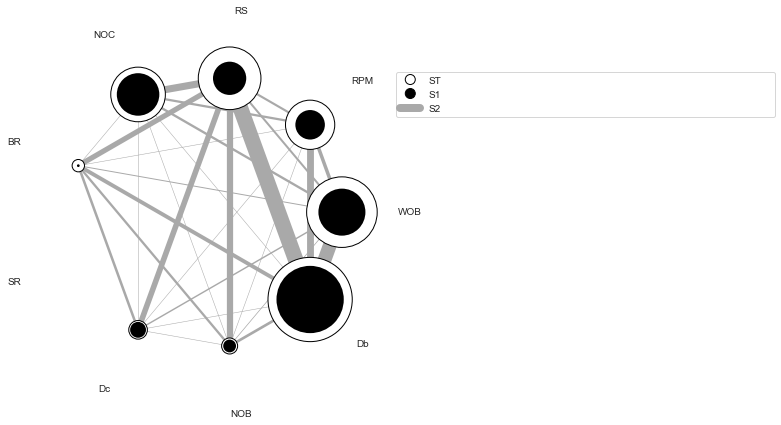

In [19]:
Interaction_Viz.Apply(Si, problem, threshold=0.0005)

Based on sensitivity analysis one can see that the main parameters are bit diameter, weight on bit, RPM, rock strength, number of cutters. It is also seen the second-order interaction between independent parameters. It is seen that mathematically there is a big interaction between RS and bit diameter, bit diameter and weight on bit, and RPM with Db. Note that these interactions are from mathematical perspective and does not necessarily represent physics.